In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats.kde import gaussian_kde
import json
import math

In [2]:
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = np.array([7,5])*0.8
plt.rcParams['figure.dpi'] = 180

In [3]:
import neurenorm

In [4]:
data = neurenorm.load_data("data.tif")

In [5]:
# This returns a list of the different renormalization steps
clusterings = {}
rdata = {} #< renormalized data
strategies = ['correlation', 'random']
for strategy in strategies:
    clusterings[strategy] = neurenorm.cluster_recursive(data, 9, clustering_strategy=strategy)
    rdata[strategy] = [neurenorm.apply_clustering(data, clusters) for clusters in clusterings[strategy]]

In [6]:
def sorted_eigenvals_for_cluster(data, cluster):
    corr_coef = neurenorm.compute_correlation_coefficients(data[cluster])
    eig_vals, _ = np.linalg.eig(corr_coef)
    return -np.sort(-eig_vals)

In [7]:
def max_likelihood_exp(x):
    xmin = np.min(x)
    mu = 1 + np.size(x) * np.reciprocal(np.sum(np.log(x/xmin)))
    return mu

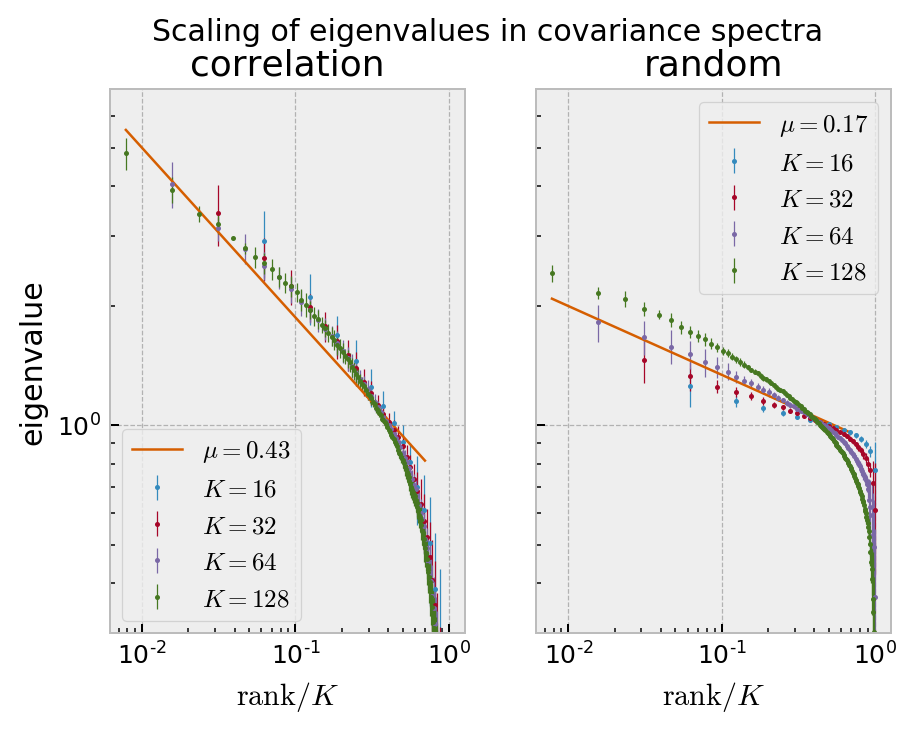

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.suptitle('Scaling of eigenvalues in covariance spectra')

power_law_max = 0.7
power_law_offset = [0.7, 0.9]

for plot_i, (ax, strategy) in enumerate(zip(axs, strategies)):
    mu_arr = []
    for index in range(4,8):
        size_k = 2**index
        clusters = clusterings[strategy][index].T
        eigen_vals = np.zeros_like(clusters, float)
        for jdex, cluster in enumerate(clusters):
            eigen_vals[jdex][...] = sorted_eigenvals_for_cluster(data, cluster)

        # eigenvalues and errors
        eig_vals_mean = np.mean(eigen_vals, axis=0)
        eig_vals_err = np.std(eigen_vals, axis=0, ddof=1)
        
        # parameter estimation
        rank = np.arange(1, len(eig_vals_mean) + 1)
        power_law = eig_vals_mean[(rank / size_k) < power_law_max]
        mu_arr.append(1.0/max_likelihood_exp(power_law))

        # plotting
        ax.errorbar(rank / size_k, eig_vals_mean, yerr=eig_vals_err, fmt='o', markersize=1, elinewidth=0.5, label="$K={}$".format(size_k))

    mu = np.mean(mu_arr, axis=0)
    x = np.linspace(1/2**7, power_law_max, 10)
    ax.plot(x, power_law_offset[plot_i] * np.power(1.0/x, mu), label="$\\mu = {{{:.2}}}$".format(mu), linewidth=1)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(0.3,7)
    ax.set_xlabel('$\mathrm{rank} / K$')
    axs[0].set_ylabel('eigenvalue')
    ax.set_title(strategy)
    ax.legend(loc=0)

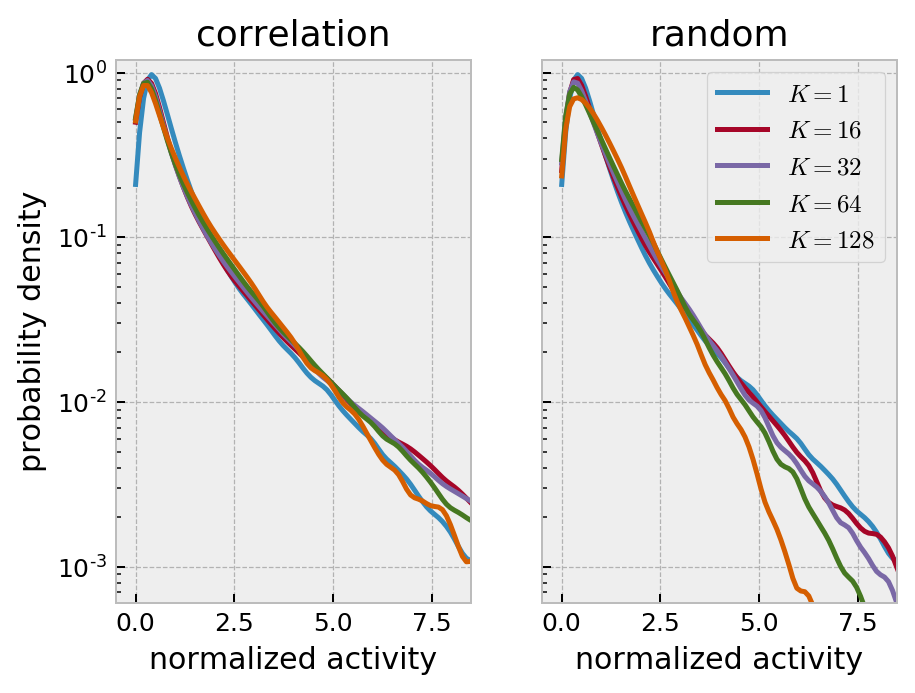

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
for plot_i, (ax, strategy) in enumerate(zip(axs, strategies)):
    for i in [0, 4, 5, 6, 7]:
        samples = rdata[strategy][i].flatten()
        samples = samples[samples > neurenorm.EPSILON]
        kde = gaussian_kde(samples, 0.15)
        x = np.linspace(0,10,100)
        ax.set_yscale('log')
        ax.set_xlim(-0.5,8.5)
        ax.plot(x, kde.pdf(x), label="$K={}$".format(2**i))

    ax.set_xlabel('normalized activity')
    ax.set_ylim(0.6*10**-3, 1.2)
    ax.set_title(strategy)

axs[0].set_ylabel('probability density')  
axs[1].legend(loc=1)
plt.show()

In [10]:
def neg_log(data):
    return -np.log(data)

[ 0.87347328 -0.02761152]
[ 0.84902047 -0.0472158 ]


Text(0, 0.5, '$-\\ln(P_0)$')

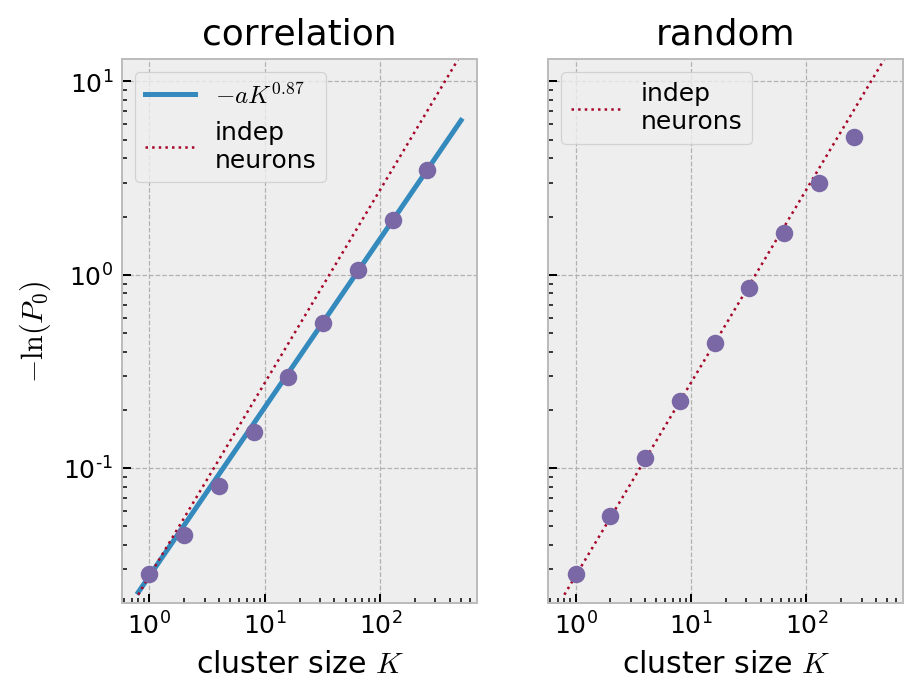

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
for plot_i, (ax, strategy) in enumerate(zip(axs, strategies)):
    p_zero, p_errs, cluster_sizes = neurenorm.compute_p_trajectory(rdata[strategy][:-1])

    # Fitting the exponents to the P_0 curve

    f = lambda x, beta, a: -a * np.power(x, beta)
    popt, perr = curve_fit(f, cluster_sizes, neg_log(p_zero))
    
    print(popt)

    x = np.linspace(.8, 500, 100)
    if plot_i == 0:
        ax.plot(x, f(x, *popt), 'C0-', label="$-a K^{{{:.2}}}$".format(popt[0]))
    ax.plot(x, f(x, 1.0, -0.02761152), 'C1:', linewidth=1, label="indep\nneurons")
    ax.errorbar(cluster_sizes, neg_log(p_zero), fmt='C2o')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(.02, 13)
    ax.set_xlabel('cluster size $K$')
    ax.legend(loc=2)
    ax.set_title(strategy)


axs[0].set_ylabel('$-\ln(P_0)$')

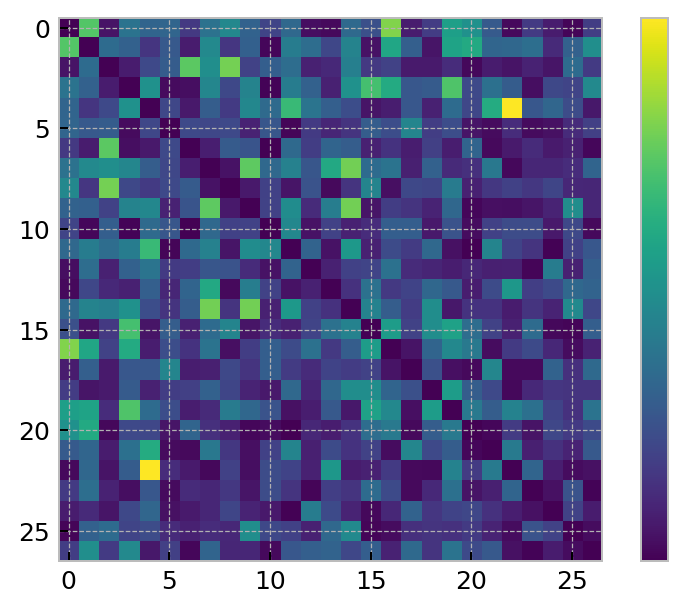

In [12]:
matrix = neurenorm.compute_correlation_coefficients(rdata['correlation'][5])
matrix = np.abs(matrix - np.identity(len(matrix)))
plt.imshow(matrix, interpolation='nearest')
colorbar = plt.colorbar(ticks = [])

In [13]:
regions_filename = './consensus_regions.json' # for other files change path accordingly
with open(regions_filename) as f:
    regions = json.load(f)

dims = [0,0]
for s in regions:
    max_x = np.max(np.array(s['coordinates'])[:,0])
    max_y = np.max(np.array(s['coordinates'])[:,1])
    dims[0] = max_x if max_x > dims[0] else dims[0]
    dims[1] = max_y if max_y > dims[1] else dims[1]
dims = (dims[0] + 1, dims[1] + 1)    

def tomask(coords):
    coords = np.array(coords)
    mask = np.zeros(dims)
    mask[coords.T[0], coords.T[1]] = 1
    return mask

masks = np.array([tomask(s['coordinates']) for s in regions])

In [14]:
def cluster_with_color(cluster, masks, color, alpha=None):
    color = matplotlib.colors.to_rgba_array(color, alpha)[0]
    cluster_im = np.sum(masks[cluster], axis=0)
    s = cluster_im.shape
    rgb_im = np.zeros((s[0], s[1], color.shape[0]))
    rgb_im[cluster_im > 0] = color
    return rgb_im

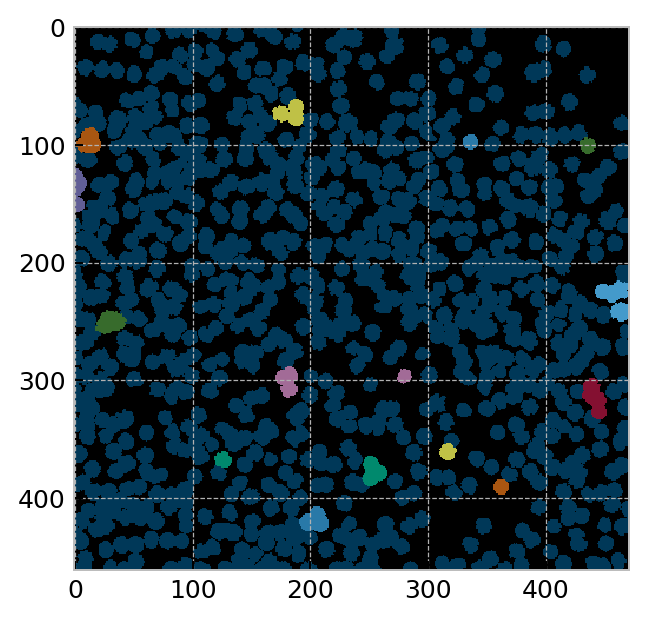

In [15]:
# show the outputs
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('black')


background = cluster_with_color(np.arange(len(masks)), masks, 'C9', 0.5)
plt.imshow(background)
for cluster_index in range(9):
    color = 'C{}'.format(cluster_index % 9)
    cluster = clusterings['correlation'][2].T[cluster_index]
    im = cluster_with_color(cluster, masks, color, 0.8)
    plt.imshow(im)
    
plt.show()